In [39]:
# Load libraries
# !pip install "numpy" "pandas" "matplotlib" "python-igraph>=0.10.4"
import random
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl  # noqa
import matplotlib.pyplot as plt

# IGraph configuration
# Set configuration variables
ig.config["plotting.backend"] = "matplotlib"  # use Matplotlib as plotting backend
ig.config["plotting.vertex_color"] = "white"
ig.config["plotting.vertex_size"] = "10"

# Fundamental generative models

Generative network models are, in essence, mathematical models (often parametrized) that define probability distributions over networks
of a given size (number of nodes), such that typical networks sampled from a given distribution tend to have some specific statistical-stuctural
properties.

Here we will review few models that were fundamental for early years of network science.

## Types of generative models

Here we will consider only so-called equilibrium models which assume fixed number of nodes. There are also more dynamic (non-equilibrium) models that
represent systems that may grow or shrink in time 
(or evolve in other fundamental ways that change the sample space, that is, the set of possible networks that can be sampled). 
Interestingly, the two families of models are closely linked to either equilibrium and non-equilibrium statistical physics.

**NOTE.**

There are also dynamic equilibrium models, in which the adjacency structure (whom connects to whom) may change in time, but the point is
that the system size stays the same. They belong to the first family of static/equilibrium models.

## Erdős-Renyi model

Here we study the classical ER model, or more concretely its $G(n, p)$ variant, where $n$ is the number of nodes and $p$ is  the connection probability.
Note that, assuming that we want to generate simple graphs, the expected node degree is:

$$
\bar{d} = \bar{d}_i = \sum_{j \neq i}^n p = p(n-1)
$$

Thus, $p$ can be mapped one-to-one to $\bar{d}$, which means that (once $n$ is fixed) all properties of the model are determined by the average
node degree, which is therefore its **control parameter**.

This is useful, because its easier to interpret $\bar{d}$ than $p$. We will use this perspective now to understand why most networks are well connected.

### Emergence of connectedness in undirected graphs

In [40]:
n = 10000                          # number of nodes
D = np.arange(.1, 5.5, .3)         # average degrees
R = 10                             # number of repetitions
F = np.empty_like(D, dtype=float)  # array for storing fractions of nodes in giant component
V = np.empty(R, dtype=float)       # array for storing replication results (F)

for i, dbar in enumerate(D):
    for j in range(R):
        p = dbar / (n-1)                                # determine p parameter as a function of dbar
        G = ig.Graph.Erdos_Renyi(n, p, directed=False)  # initialize graph object
        giant = G.components().giant()                  # extract giant component
        frac = giant.vcount() / G.vcount()              # calculate fraction of nodes in the giant component
        V[j] = frac
    F[i] = V.mean()   # average results over 'R' replications

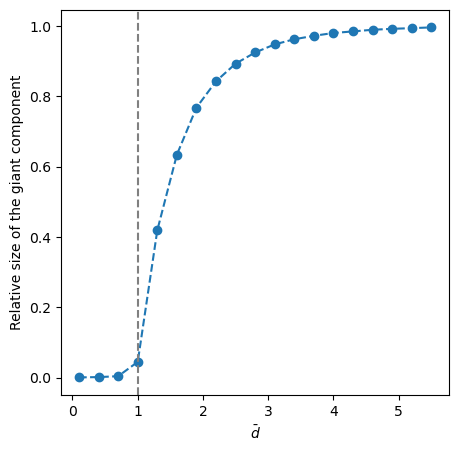

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(D, F, marker="o", ls="--")
ax.axvline(1, ls="--", color="gray")
ax.set_xlabel(r"$\bar{d}$")
_ = ax.set_ylabel("Relative size of the giant component")

Let us see what happens a little bit more visually based on smaller networks.

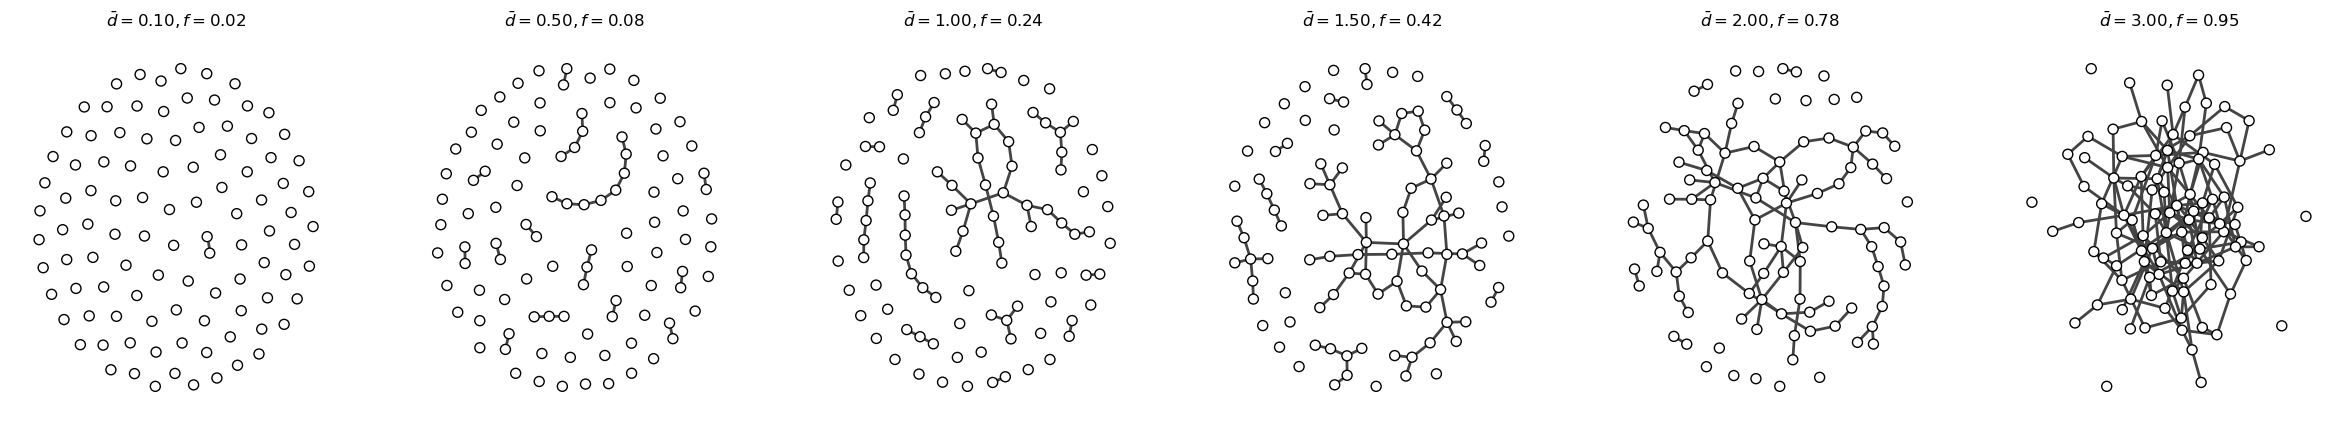

In [42]:
random.seed(303) # IGraph uses Python standard pseudorandom generator

n = 100
D = np.array([.1, .5, 1, 1.5, 2, 3])

fig, axes = plt.subplots(ncols=len(D), figsize=(len(D)*5, 5))

for ax, dbar in zip(axes.flat, D):
    p = dbar / (n-1)
    G = ig.Graph.Erdos_Renyi(n, p, directed=False)
    giant = G.components().giant()
    frac = giant.vcount() / G.vcount()
    ig.plot(G, target=ax)
    ax.set_title(rf"$\bar{{d}} = {dbar:.2f}, f = {frac:.3}$")

The critical value of $\bar{d} = 1$ defines a **percolation threshold** of the system. This name points to the connection between the
emergence of connectedness in random graphs and the physical process of **percolation**, that is, the movement of particles through porous
materials. This is a very general idea that can be used, for instance, to model forest fires.

**Question.**

Do you see why percolation is connected to forest fires? (we will study this in more detail later)

### Connectedness and sparsity

Note that $\bar{d} = p(n-1) \Longrightarrow p = \bar{d}/(n-1)$. In other words, when $\bar{d}$ is held fixed, $p$ goes to zero as we increase $n$.
Since $\bar{d}$ is the sole controll parameter determining the percolation threshold, it means that percolation can be reached for abitrarily small
values of $p$ if the system is large enough. So connectedness is possible, and in fact almost guaranteed, even in sparse systems.

This is why **real networks are connected** (roughly).

### Average shortest paths

It is also instructive to see how average shortest paths scale with the system size in ER graphs above the percolation threshold.
We will see that:

$$L \propto \log{n}$$

In other words, in random graphs average shortest paths scale proportionally to the logarithm of the number of nodes,
which means they grow very slowly with the system size.

In [43]:
N = np.array([16, 32, 64, 128, 256, 512, 1024, 2048, 4096])  # numbers of nodes
L = np.empty_like(N, dtype=float)                            # array for storing average path lengths
dbar = 4                                                     # average degree
R = 5                                                        # number of repetitions
V = np.empty(5, dtype=float)                                 # array for storing L repetitions

for i, n in enumerate(N):
    p = dbar/(n-1)
    for j in range(R):
        G = ig.Graph.Erdos_Renyi(n, p, directed=False)
        V[j] = G.average_path_length()
    L[i] = V.mean()

Text(0.02, 0.5, 'Average shortest path')

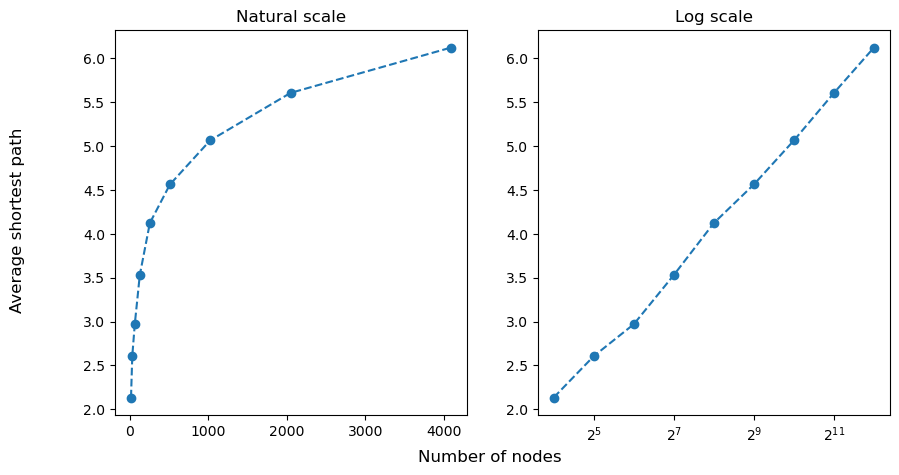

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for ax, log in zip(axes.flat, [False, True]):
    ax.plot(N, L, marker="o", ls="--")
    if log:
        ax.set_xscale("log", base=2)
        ax.set_title("Log scale")
    else:
        ax.set_title("Natural scale")

fig.supxlabel("Number of nodes")
fig.supylabel("Average shortest path")

### Percolation in directed random graphs

Now we consider percolation in directed graphs. In this case the situation is slightly more complex since we have two distinct notions
of components.

* **Strongly connected component.** Each node is connected to any other node by a directed path.
* **Weakly connected component.** Each node is connected to any other node by a semipath (i.e. ignoring edge directions).

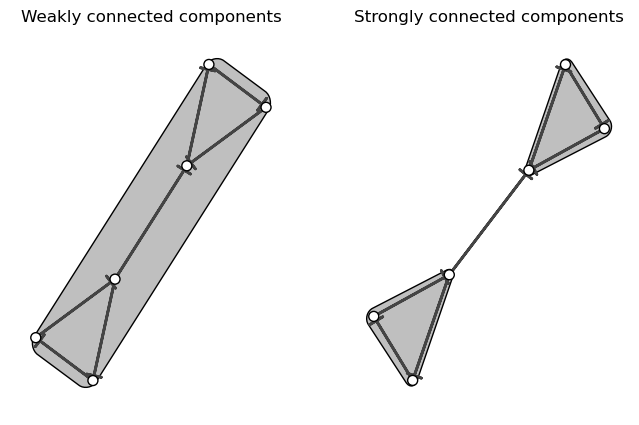

In [45]:
G = ig.Graph(directed=True)
G.add_vertices(6)
G.add_edges([
    (0, 1),
    (1, 2),
    (2, 0),
    (3, 4),
    (4, 5),
    (5, 3),
    (0, 3)
])

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))

for ax, mode in zip(axes.flat, ["weak", "strong"]):
    comps = G.components(mode=mode)
    ig.plot(G, mark_groups=comps, target=ax, edge_arrow_size=.02)
    ax.set_title(f"{mode.title()}ly connected components")

In [46]:
n = 10000                          # number of nodes
D = np.arange(.1, 5.5, .3)         # average degrees
R = 10                             # number of repetitions
W = np.empty_like(D, dtype=float)  # array for storing fractions of nodes in weakly connected giant component
S = np.empty_like(D, dtype=float)  # array for storing fractions of nodes in strongly connected giant component
V = np.empty((R, 2), dtype=float)  # array for storing replication results (F)

for i, dbar in enumerate(D):
    for j in range(R):
        p = dbar / (n-1)                                # determine p parameter as a function of dbar
        G = ig.Graph.Erdos_Renyi(n, p, directed=True)   # initialize graph object (directed)
        V[j, 0] = G.components("weak").giant().vcount() / n
        V[j, 1] = G.components("strong").giant().vcount() / n
    W[i] = V[:, 0].mean()
    S[i] = V[:, 1].mean()

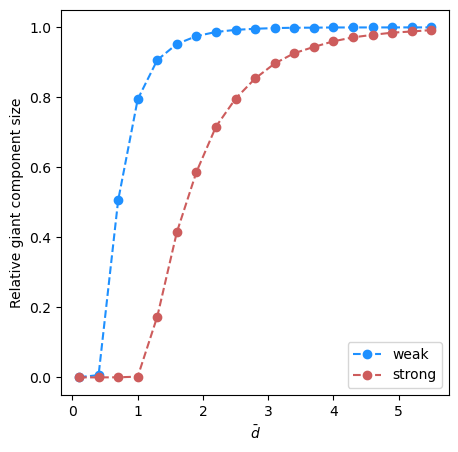

In [47]:
fig, ax = plt.subplots(figsize=(5,5))

style = dict(marker="o", ls="--")
ax.plot(D, W, **style, color="dodgerblue", label="weak")
ax.plot(D, S, **style, color="indianred", label="strong")
ax.set_xlabel(r"$\bar{d}$")
ax.set_ylabel("Relative giant component size")
_ = ax.legend()

Clearly, strong percolation happens later than weak percolation but again at $\bar{d} = 1$, while weak percolation happens at roughly
$\bar{d} = 1/2$.

**Question.**

Do you know why?

## Random geometric graphs and locality principle

In ER graphs connections are scattered randomly across the whole system. This presupposes that nodes possess a kind of **global knowledge**
about the system **when establishing connections**. (This point is even clearer when we consider a process in which new nodes arrive
and link to existing nodes at random.)

Such an assumption may not be very reasonable in some contexts. So how can we conceive of a graph in which connections are trully localized?

There are many ways to do this, but probably a simplest model is given by **Random Geometric Graphs** (RGG).

In the the most classical RGG variant $n$ nodes are scattered uniformly at random over a unit square
(perhaps wrapped as a torus, so it does not have boundaries) and then nodes which are at a distance
$r$ or lower are connected. Here, $r$ is the control parameter which fully determines the properties
of the induced ensemble of graphs.

**NOTE.**

Ensemble of graphs is a fany term for a specific probability distribution over graphs.

**SIDE NOTE.**

Many real systems, from social to brain networks, share many properties with random geometric graphs.

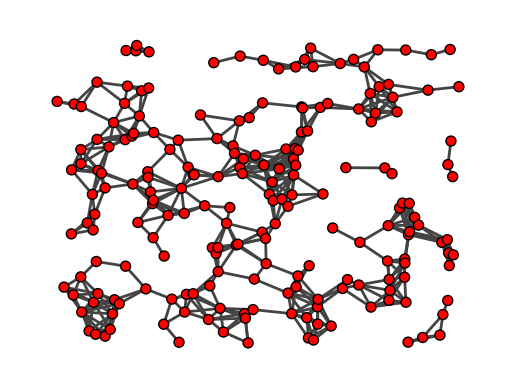

In [48]:
G = ig.Graph.GRG(200, radius=.1, torus=False)
ig.plot(G, vertex_color="red")

Note that if we assume toroidal embedding (so no boundary) it is easy to get an exact expression for the expected average node degree
in an RGG. Since nodes are distributed uniformly at random over the unit square, it is enough to consider the relative area of a unit
circle of radius $r$ to the area of a unit square (which is equal to $1$). Thus, we have that:

$$
\bar{d} = \frac{\pi{}r^2}{1}(n-1) = \pi{}r^2(n-1)
$$

Hence, to get the radius producing a desired average degree we consider:

$$
r = \sqrt{\frac{\bar{d}}{\pi{}(n-1)}} 
$$

So, we see that we can quite easily controll the basic properties of the model.

### Percolation, clustering and average path lengths in random geometric graphs

Clearly, the locality principle encoded in RGGs enforces some degree of transitvity of relations leading, perhaps, to non-trivial
levels of clustering. But how does it affect percolation and average path lengths?

Note that conditional on nodes' positions the RGG model is fully deterministic, so we are now in a regime very different from ER random graphs.

In [49]:
n = 10000                          # number of nodes
D = np.arange(.5, 8, .5)           # average degrees
R = 10                             # number of repetitions
C = np.empty_like(D, dtype=float)  # array for storing clustering coefficients
F = np.empty_like(C)               # array for storing fractions of nodes in giant component
V = np.empty((R, 2), dtype=float)  # array for storing replication results (F)

for i, dbar in enumerate(D):
    for j in range(R):
        r = np.sqrt(dbar / (np.pi*(n-1)))                     # determine connection radius
        G = ig.Graph.GRG(n, r, torus=True)                    # we use toroidal model to avoid boundary effects
        clust = G.transitivity_undirected()                   # global clustering
        frac  = G.components().giant().vcount() / G.vcount()  # fraction in giant component
        V[j, 0] = clust
        V[j, 1] = frac
    C[i] = V[:, 0].mean()
    F[i] = V[:, 1].mean()

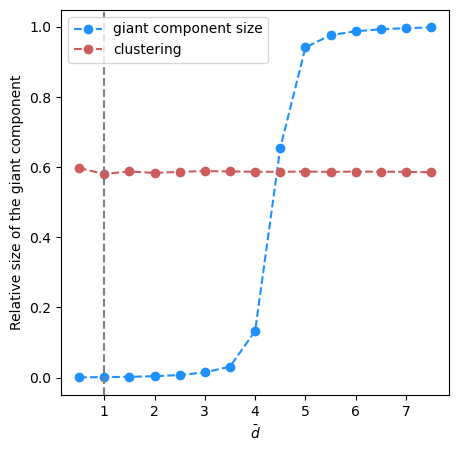

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))

style = dict(marker="o", ls="--")
ax.plot(D, F, **style, color="dodgerblue", label="giant component size")
ax.plot(D, C, **style, color="indianred", label="clustering")
ax.axvline(1, ls="--", color="gray")
ax.set_xlabel(r"$\bar{d}$")
_ = ax.set_ylabel("Relative size of the giant component")
ax.legend()

We see that in this model clustering is (at least for some range of $r$ parameter values) is independent of average degree 
(and therefore also edge density) as well as percolation. This is a non-trivial results, because it shows that:

* Percolation and connectedness is possible also in purely localized systems.
* Localized systems with high clustering can be sparse.

### Problem.

Show that RGG is a good model of forest fire (or spatial percolation more generally). 
To this purpose, draw RGG graphs with 200 nodes and increasing radii such that some are below
the percolation threshold and some above.

**NOTE.**

`Graph.GRG` instances comes with `x` and `y` attributes defined on vertices. They are used automatically by `igraph` for plotting,
so you do not need to worry about positioning the nodes.

**HINT.**

Try repurposing the code from the chunk above as well as the earlier code we used to show percolation on small ER random graphs.

### Problem.

Provide a code-based demonstration of the small-world effect using RGG model.
Namely, show the evolution of clustering coefficient (global or average local)
and average shortest path in RGG graphs of different sizes with different probabilities
of edge rewiring.

**HINT.**

Try to use `.rewire_edges` method defined on graph objects.

## Preferential attachment

Now we turn to the famous **Preferential Attachment** (PA) model, which provides one of several good explanations for the ubiquitousness
of right-skewed degree distributions.

### Degree distributions in ER and RGG models

But first let us note that degree distributions produced by ER and RGG models that we considered so far binomial and roughly symmetric.
This is why we need tools like PA model, because otherwise we would not be able to understand the origins of heavy-tailed degree distributions.

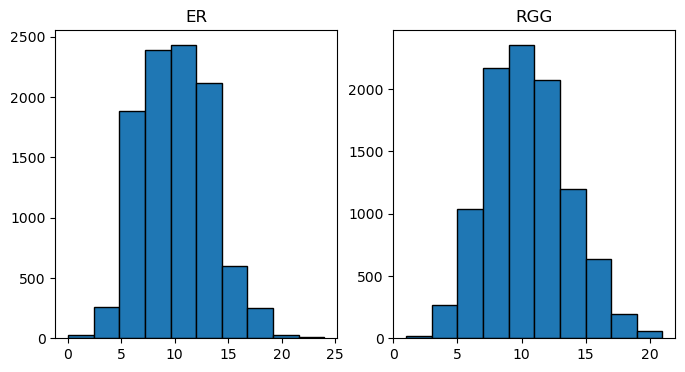

In [51]:
n    = 10000
dbar = 10

graphs = {
    "ER":  ig.Graph.Erdos_Renyi(n, p=dbar/(n-1)),
    "RGG": ig.Graph.GRG(n, radius=np.sqrt(dbar/(np.pi*(n-1))), torus=True)
}

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

for ax, name in zip(axes.flat, graphs):
    graph = graphs[name]
    ax.hist(graph.degree(), edgecolor="black")
    ax.set_title(name)

### Degree distribution in PA model

Below we demonstrate the PA model and how it evolves towards right-skewed distributions.

Remember that it is governed by the following dynamics:

1. Start with an arbitrary graph.
2. Create new node. It links to $m$ existing nodes with probabilities proportional to their degrees.
3. Repeat (2).

In [52]:
n  = 20
m1 = 2
# Seed graph
G  = ig.Graph.Erdos_Renyi(n, p=5/(n-1), directed=False)

waves = [50, 100, 350, 500, 1000]
graphs = [G]

for n_nodes in np.cumsum(waves):
    n_edges = np.random.randint(1, m1+1, n_nodes)
    new = ig.Graph.Barabasi(n_nodes, m=1, directed=False, start_from=graphs[-1])
    graphs.append(new)

layout = graphs[-1].layout_kamada_kawai()

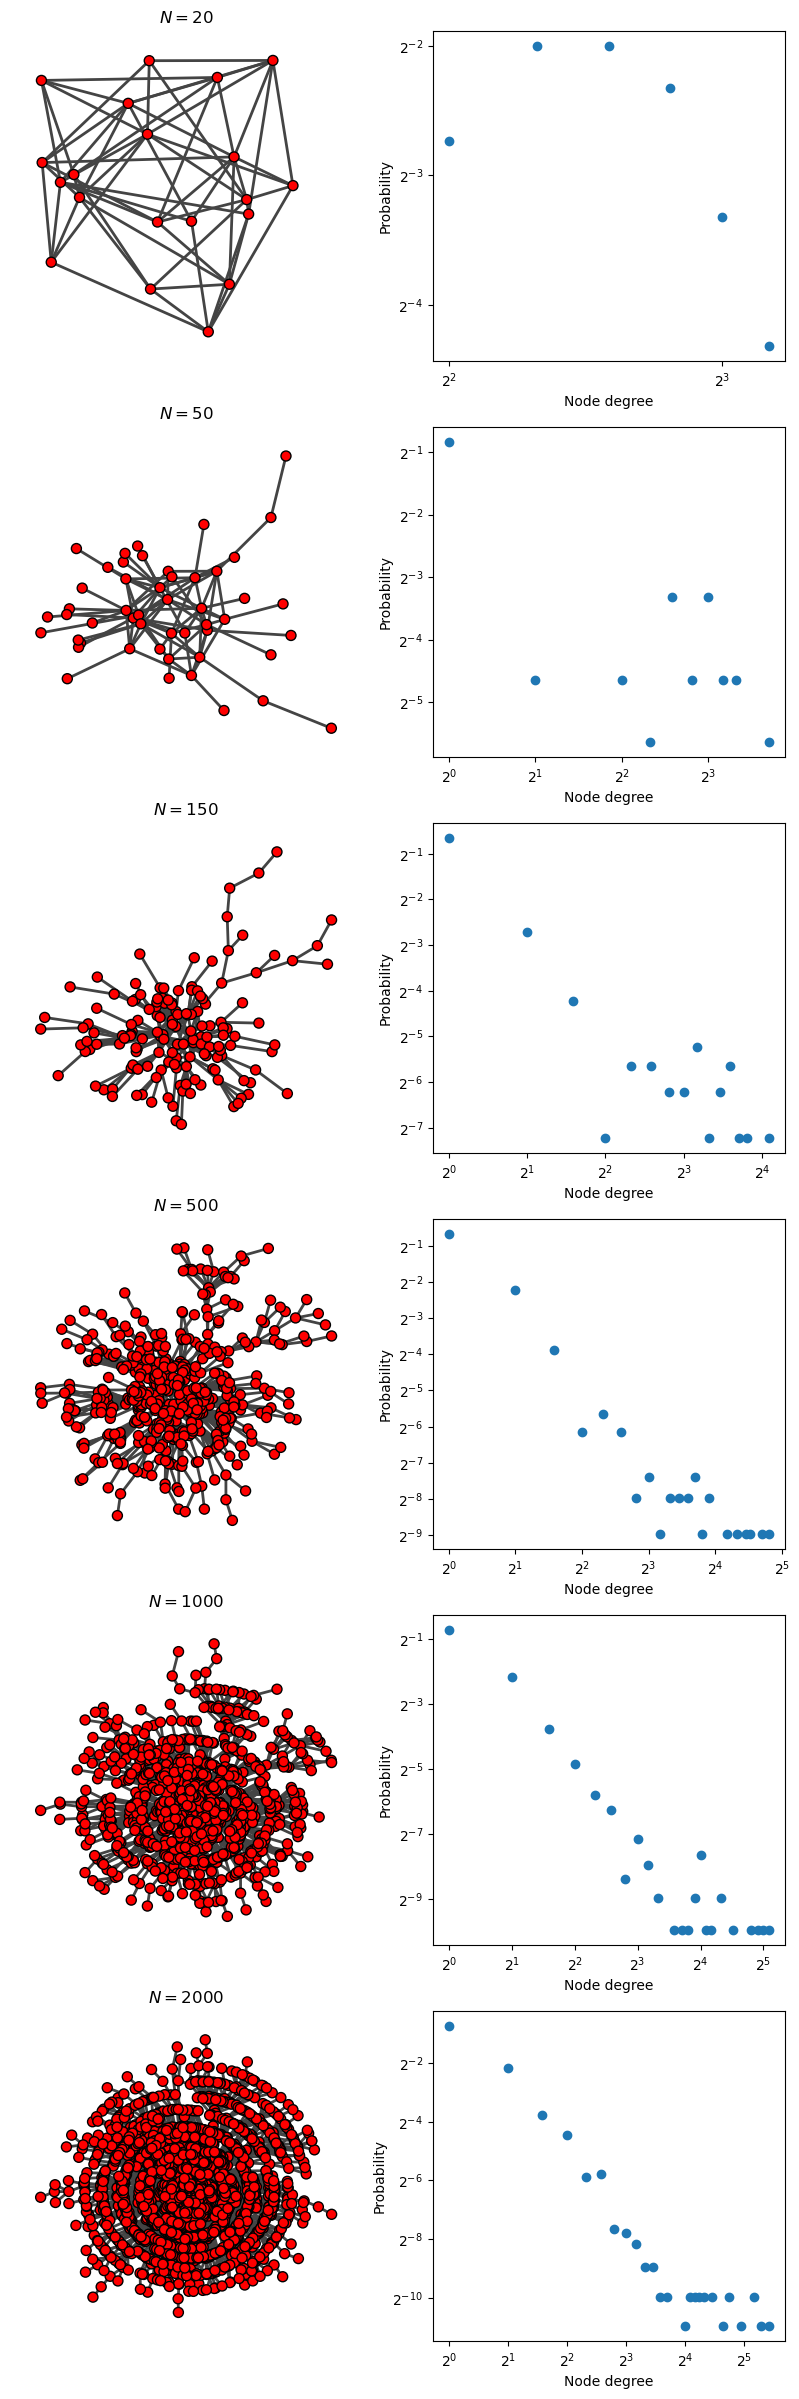

In [53]:
fig, axes = plt.subplots(nrows=len(graphs), ncols=2, figsize=(10, 5*len(graphs)))

for axrow, graph in zip(axes, graphs):
    ax = axrow[0]
    ig.plot(graph, layout=layout[:graph.vcount()], vertex_color="red", target=ax)
    ax.set_title(rf"$N = {graph.vcount()}$")
    ax = axrow[1]
    D = pd.Series(graph.degree()) # get degree sequence
    C = D.value_counts()          # count occurence of unique values
    P = C / C.sum()               # calculate probability distribution

    # Plot probability distribution in log-log scale
    ax.scatter(P.index, P)
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_xlabel("Node degree")
    ax.set_ylabel("Probability")

## Where does complexity come from?

Now we are ready to make an attempt at understanding what it means for a network to be complex.
As we have seen, some of the salient features of networks emerge from randomness, while some other
arise as consequences of strict deterministic rules. And since real-world complex networks tend
to have feature characteristic for both randomness and deterministic structuration, it must be
that complexity arises from a dialectical interaction between this two seemingly opposed forces.

We will now work through a simple example of data generating process based on mixing structured
patterns with noise, which will produce networks with some of the salient features.
The idea is generate two networks by overlaying RGG and PA networks as layers, then combine
the two networks and finally inject some noise to connect the two otherwise disconnected
components and ensure properties specific for random graphs (e.g. small path lengths).

* **RGG** component is responsible for producing small scale localized structures
  yielding non-trivial clustering (transitivity of relations),
* **PA** component provides more right-skewed degree distribution endowing the network
  with some structural hierarchy (some nodes are much better connected and important than others).
* **Random** component ensure short path lengths and connectedness.

In [54]:
def make_subgraph(n, dbar, m=1, label=""):
    """Function for making a graph composed of RGG and PA layers.

    Parameters
    ----------
    n
        Number of nodes.
    dbar
        Expected average degree of the RGG layer.
    m
        Edge per new node in the PA layer.
    label
        Label used for naming graph.

    Returns
    -------
    graph
        Graph with RGG and PA layers combined.
    rgg
        RGG graph.
    pa
        PA graph.
    """
    rgg = ig.Graph.GRG(n, radius=np.sqrt(dbar/(np.pi*(n-1))))
    if isinstance(m, tuple):
        m0, m1 = m
        m = list(np.random.randint(m0, m1+1, n))
    pa  = ig.Graph.Barabasi(n, m=m, directed=False)
    graph = ig.union([rgg, pa])
    del graph.vs["x"]
    del graph.vs["y"]
    graph.vs["name"] = [ f"{label}{vid}" for vid in graph.vs.indices ]
    graph.vs["group"] = label
    return graph, rgg, pa

In [55]:
random.seed(303)
np.random.seed(304)

sub1, rgg1, pa1 = make_subgraph(1000, 5, m=(1, 2), label="a")
sub2, rgg2, pa2 = make_subgraph(1000, 3, m=(1, 3), label="b")

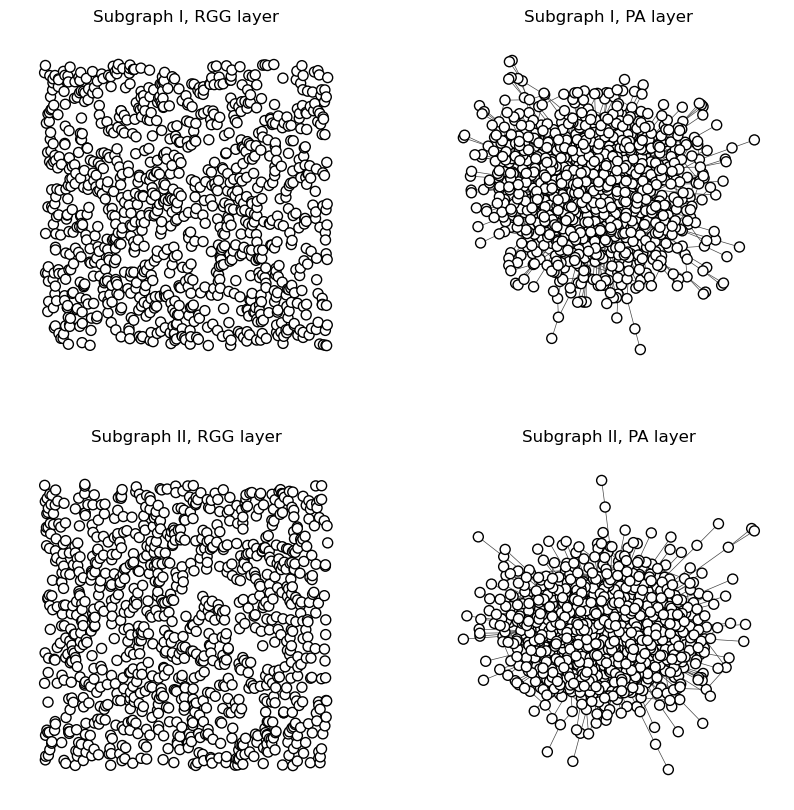

In [56]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

ax = axes[0, 0]
ig.plot(rgg1, target=ax)
ax.set_title("Subgraph I, RGG layer")
ax = axes[0, 1]
ig.plot(pa1, target=ax, edge_width=.5)
ax.set_title("Subgraph I, PA layer")

ax = axes[1, 0]
ig.plot(rgg2, target=ax)
ax.set_title("Subgraph II, RGG layer")
ax = axes[1, 1]
ig.plot(pa2, target=ax, edge_width=.5)
_ = ax.set_title("Subgraph II, PA layer")

In [57]:
## Combine subgraphs
G = ig.union([sub1, sub2])

## Add noise by rewiring edges
## We use a rewiring algorithm that does not
## change the degree sequence.
G.rewire(int(.1*G.ecount()))

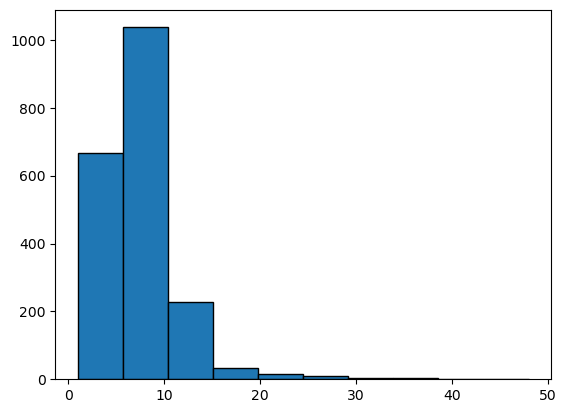

In [58]:
D = np.array(G.degree())
_ = plt.hist(D, edgecolor="black")

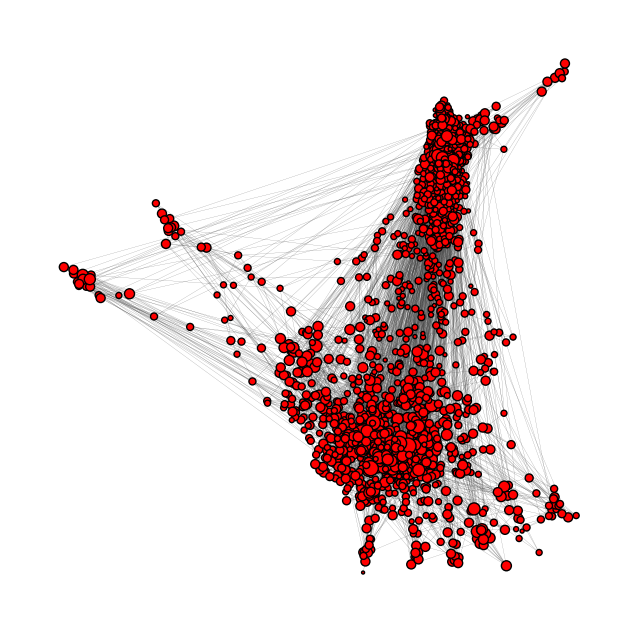

In [59]:
fig, ax = plt.subplots(figsize=(8, 8))

ig.plot(G, target=ax, vertex_size=3*np.sqrt(D), vertex_color="red", edge_width=.1)

### Homework

Analyze the structure of the network we just created.

1. Calculate clustering coefficient (global and/or average local). How does it compare to edge density?
2. Plot average local clustering coefficients grouped by node degrees. How do you interpret the pattern you see?
3. Use `.assortativity_degree` to calculate Pearson correlation between degrees of connected nodes. What does the value tell you about preferences of nodes?
4. Check the documentation of `.assortativity_nominal` method. Use to calculate assortativity with respect to `.vs["group"]` vertex attribute.
   What does the value tell you about the extent to which the injected noise destroyed the information about the two original subgraphs?
5. Re-plot the graph and color nodes by their betweeness (using `.betweenness` method). Where do you find nodes with highest values
   and what does it mean?